# Show that the muon and proton detection effieciencies are decoupled

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected_cosmic.csv, loading it...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv and found the file...
9933 selected CC1p events overlay


# What is the acceptance as a function of $p_p$ and $\theta_p$ in different bins of $p_\mu$ and $\theta_\mu$

In [3]:
def sample_in_xy_bin(sample,xmin,xmax,ymin,ymax,xvar,yvar):
    return sample[(xmin<sample[xvar])
                  &(sample[xvar]<xmax)
                  &(ymin<sample[yvar])
                  &(sample[yvar]<ymax)]

def sample_in_muon_bin(sample,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max):
    return sample_in_xy_bin(sample,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max,xvar='truth_Pmu',yvar='truth_Pmu_cos_theta')
def sample_in_proton_bin(sample,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max):
    return sample_in_xy_bin(sample,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max,xvar='truth_Pp',yvar='truth_Pp_cos_theta')

In [4]:
large_bins_Pmu_min = np.array([0,0.45])
large_bins_Pmu_max = np.array([large_bins_Pmu_min[1],2])
large_bins_Pmu_centers = 0.5*(large_bins_Pmu_min+large_bins_Pmu_max)
large_bins_Pmu_cos_theta_min = np.array([-0.2,0.5])
large_bins_Pmu_cos_theta_max = np.array([large_bins_Pmu_cos_theta_min[1],1])
large_bins_Pmu_cos_theta_centers = 0.5*(large_bins_Pmu_cos_theta_min+large_bins_Pmu_cos_theta_max)

hCC1p_muon_bins = np.zeros((2,2))

# proton acceptance parameters
NpBins = 5
Pp_bins = linspace(0.3,1.,NpBins)
Pp_cos_theta_bins = linspace(0.2,1,NpBins)
Pp_xcenters,Pp_cos_theta_ycenters = 0.5*(Pp_bins[1:]+Pp_bins[:-1]),0.5*(Pp_cos_theta_bins[1:]+Pp_cos_theta_bins[:-1])
nx_p,ny_p = len(Pp_bins)-1,len(Pp_cos_theta_bins)-1

# 1D efficiency

In [6]:
Pp_bins = linspace(0.3,1.,10); mid_Pp = 0.5*(Pp_bins[1:]+Pp_bins[:-1]); bin_width_Pp=(mid_Pp[1]-mid_Pp[0])
Pp_cos_theta_bins = linspace(0.2,1,10); mid_Pp_cos_theta = 0.5*(Pp_cos_theta_bins[1:]+Pp_cos_theta_bins[:-1]); bin_width_Pp_cos_theta=(mid_Pp_cos_theta[1]-mid_Pp_cos_theta[0])

In [7]:
heff,heff_err = dict(), dict()
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        key = 'iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)
        selected_CC1p_muon_bin = sample_in_muon_bin(selected_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
        genie_CC1p_muon_bin = sample_in_muon_bin(genie_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)        
        effCC1p_muon_bin = float(len(selected_CC1p_muon_bin))/len(genie_CC1p_muon_bin)

        heff[key],heff_err[key] = [],[]
        for iPp in range(len(Pp_bins)-1):
            Pp_min,Pp_max = Pp_bins[iPp],Pp_bins[iPp+1]    
            # efficiency
            gen_proton_bin = sample_in_proton_bin(genie_CC1p_muon_bin,Pp_min,Pp_max,-1,1)            
            acc_proton_bin = sample_in_proton_bin(selected_CC1p_muon_bin,Pp_min,Pp_max,-1,1)
            Ngen = float(len(gen_proton_bin))
            Nacc = float(len(acc_proton_bin))
            heff[key].append( (1./effCC1p_muon_bin)*Nacc/Ngen if Ngen>0 else 0 )
            heff_err[key].append( heff[key][-1]*np.sqrt( (1./Nacc if Nacc>0 else 0) 
                                                    + (1./Ngen if Ngen>0 else 0)) )        
print 'done.'

done.


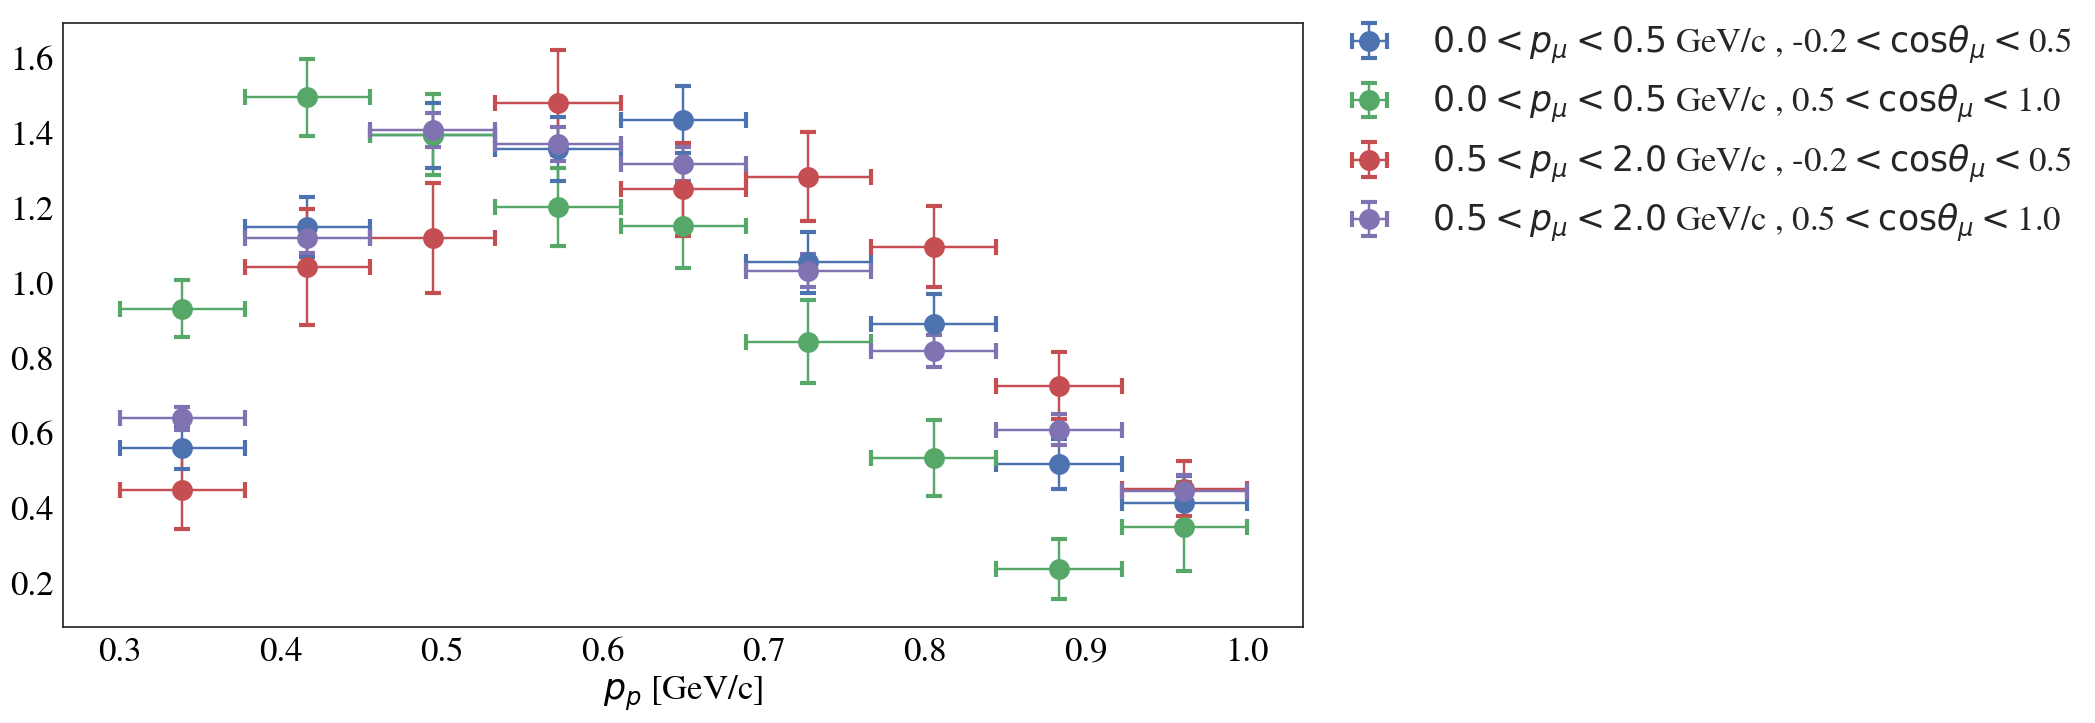

In [8]:
fig,ax=plt.subplots(figsize=(16,8))
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        key = 'iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)
        ax.errorbar(x=mid_Pp,xerr=0.5*bin_width_Pp,y=heff[key],yerr=heff_err[key]
                    ,fmt='o',markersize=15,capsize=6,capthick=3
                    ,label=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max))        
set_axes(ax,r'$p_p$ [GeV/c]')
ax.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

In [9]:
heff,heff_err = dict(), dict()
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        key = 'iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)
        selected_CC1p_muon_bin = sample_in_muon_bin(selected_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
        genie_CC1p_muon_bin = sample_in_muon_bin(genie_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)        
        effCC1p_muon_bin = float(len(selected_CC1p_muon_bin))/len(genie_CC1p_muon_bin)

        heff[key],heff_err[key] = [],[]
        for iPp_cos_theta in range(len(Pp_cos_theta_bins)-1):
            Pp_cos_theta_min,Pp_cos_theta_max = Pp_cos_theta_bins[iPp_cos_theta],Pp_cos_theta_bins[iPp_cos_theta+1]    
            # efficiency
            gen_proton_bin = sample_in_proton_bin(genie_CC1p_muon_bin,0,2,Pp_cos_theta_min,Pp_cos_theta_max)            
            acc_proton_bin = sample_in_proton_bin(selected_CC1p_muon_bin,0,2,Pp_cos_theta_min,Pp_cos_theta_max)
            Ngen = float(len(gen_proton_bin))
            Nacc = float(len(acc_proton_bin))
            heff[key].append( (1./effCC1p_muon_bin)*Nacc/Ngen if Ngen>0 else 0 )
            heff_err[key].append( heff[key][-1]*np.sqrt( (1./Nacc if Nacc>0 else 0) 
                                                    + (1./Ngen if Ngen>0 else 0)) )        
print 'done.'

done.


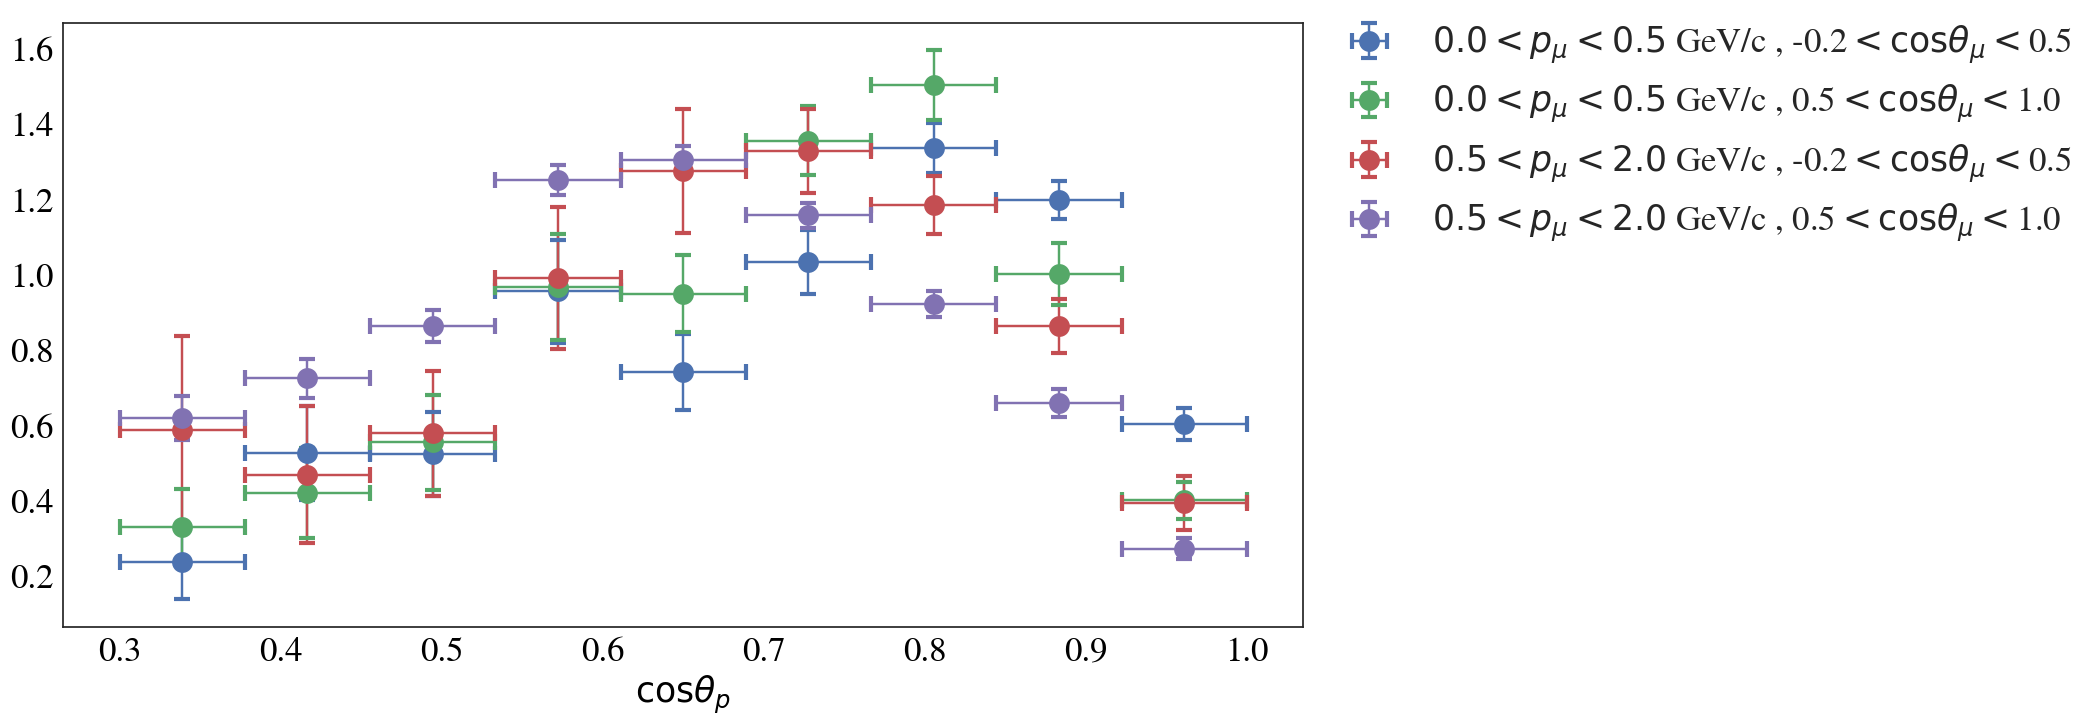

In [10]:
fig,ax=plt.subplots(figsize=(16,8))
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        key = 'iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)
        ax.errorbar(x=mid_Pp,xerr=0.5*bin_width_Pp,y=heff[key],yerr=heff_err[key]
                    ,fmt='o',markersize=15,capsize=6,capthick=3
                    ,label=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max))        
set_axes(ax,r'$\cos\theta_p$')
ax.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

## muon efficeincy in proton bins

In [62]:
large_bins_Pp_min = np.array([0.3,0.7])
large_bins_Pp_max = np.array([large_bins_Pp_min[1],2])
large_bins_Pp_centers = 0.5*(large_bins_Pp_min+large_bins_Pp_max)
large_bins_Pp_cos_theta_min = np.array([0.,0.6])
large_bins_Pp_cos_theta_max = np.array([large_bins_Pp_cos_theta_min[1],1])
large_bins_Pp_cos_theta_centers = 0.5*(large_bins_Pp_cos_theta_min+large_bins_Pp_cos_theta_max)

In [63]:
Pmu_bins = linspace(0.2,1.2,14); mid_Pmu = 0.5*(Pmu_bins[1:]+Pmu_bins[:-1]); bin_width_Pmu=(mid_Pmu[1]-mid_Pmu[0])
Pmu_cos_theta_bins = linspace(-0.3,1,13); mid_Pmu_cos_theta = 0.5*(Pmu_cos_theta_bins[1:]+Pmu_cos_theta_bins[:-1]); bin_width_Pmu_cos_theta=(mid_Pmu_cos_theta[1]-mid_Pmu_cos_theta[0])

In [64]:
h_mu_eff,h_mu_eff_err = dict(),dict()
h_mu_gen,h_mu_acc = dict(),dict()
heff,heff_err = dict(), dict()
for iPp,(Pp_min,Pp_max) in enumerate(zip(large_bins_Pp_min,large_bins_Pp_max)):
    for iPp_cos_theta,(Pp_cos_theta_min,Pp_cos_theta_max) in enumerate(zip(large_bins_Pp_cos_theta_min,large_bins_Pp_cos_theta_max)):
        key = 'iPp %d iPp_cos_theta %d'%(iPp,iPp_cos_theta)

        genie_CC1p_proton_bin = sample_in_proton_bin(genie_CC1p,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)
        selected_CC1p_proton_bin = sample_in_proton_bin(selected_CC1p,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)
        print len(genie_CC1p_proton_bin),'genie in bin',len(selected_CC1p_proton_bin),'events in bin'
        effCC1p_proton_bin = float(len(selected_CC1p_proton_bin))/len(genie_CC1p_proton_bin)

        heff[key],heff_err[key] = [],[]
        for iPmu in range(len(Pmu_bins)-1):
            Pmu_min,Pmu_max = Pmu_bins[iPmu],Pmu_bins[iPmu+1]    
            # efficiency
            gen_muon_bin = sample_in_muon_bin(genie_CC1p_proton_bin,Pmu_min,Pmu_max,-1,1)            
            acc_muon_bin = sample_in_muon_bin(selected_CC1p_proton_bin,Pmu_min,Pmu_max,-1,1)
            Ngen = float(len(gen_muon_bin))
            Nacc = float(len(acc_muon_bin))
            heff[key].append( (1./effCC1p_proton_bin)*Nacc/Ngen if Ngen>0 else 0 )
            heff_err[key].append( heff[key][-1]*np.sqrt( (1./Nacc if Nacc>0 else 0) 
                                                    + (1./Ngen if Ngen>0 else 0)) )        
#         print heff[key]
print 'done.'

16919 genie in bin 2827 events in bin
29328 genie in bin 4745 events in bin
2404 genie in bin 253 events in bin
19362 genie in bin 2050 events in bin
done.


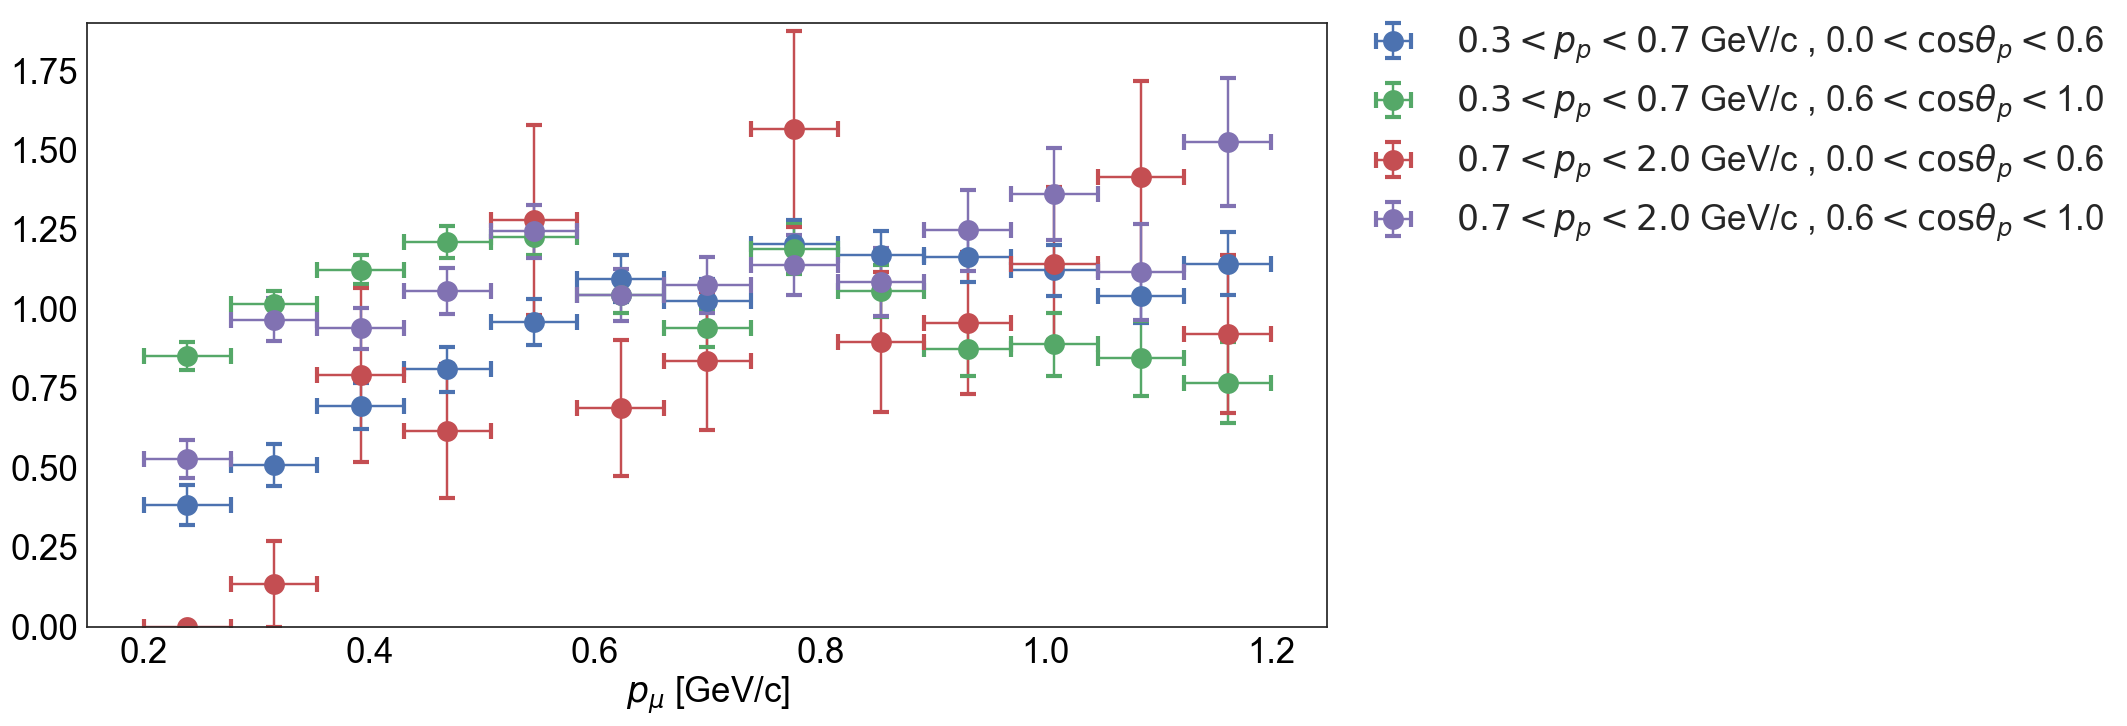

In [65]:
sns.set_style('white')
fig,ax=plt.subplots(figsize=(16,8))
for iPp,(Pp_min,Pp_max) in enumerate(zip(large_bins_Pp_min,large_bins_Pp_max)):
    for iPp_cos_theta,(Pp_cos_theta_min,Pp_cos_theta_max) in enumerate(zip(large_bins_Pp_cos_theta_min,large_bins_Pp_cos_theta_max)):
        key = 'iPp %d iPp_cos_theta %d'%(iPp,iPp_cos_theta)
        ax.errorbar(x=mid_Pmu,xerr=0.5*bin_width_Pmu,y=heff[key],yerr=heff_err[key]
                    ,fmt='o',markersize=15,capsize=6,capthick=3
                    ,label=r'$%.1f<p_p<%.1f$ GeV/c , %s$<\cos\theta_p<$%s'%(Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max))        
set_axes(ax,r'$p_\mu$ [GeV/c]',ylim=(0,1.9))
ax.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

In [66]:
h_mu_eff,h_mu_eff_err = dict(),dict()
h_mu_gen,h_mu_acc = dict(),dict()
heff,heff_err = dict(), dict()
for iPp,(Pp_min,Pp_max) in enumerate(zip(large_bins_Pp_min,large_bins_Pp_max)):
    for iPp_cos_theta,(Pp_cos_theta_min,Pp_cos_theta_max) in enumerate(zip(large_bins_Pp_cos_theta_min,large_bins_Pp_cos_theta_max)):
        key = 'iPp %d iPp_cos_theta %d'%(iPp,iPp_cos_theta)

        selected_CC1p_proton_bin = sample_in_proton_bin(selected_CC1p,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)
        genie_CC1p_proton_bin = sample_in_proton_bin(genie_CC1p,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)
        print len(selected_CC1p_proton_bin),'events in bin'
        effCC1p_proton_bin = float(len(selected_CC1p_proton_bin))/len(genie_CC1p_proton_bin)


        heff[key],heff_err[key] = [],[]
        for iPmu_cos_theta in range(len(Pmu_cos_theta_bins)-1):
            Pmu_cos_theta_min,Pmu_cos_theta_max = Pmu_cos_theta_bins[iPmu_cos_theta],Pmu_cos_theta_bins[iPmu_cos_theta+1]    
            # efficiency
            gen_muon_bin = sample_in_muon_bin(genie_CC1p_proton_bin,0,2,Pmu_cos_theta_min,Pmu_cos_theta_max)            
            acc_muon_bin = sample_in_muon_bin(selected_CC1p_proton_bin,0,2,Pmu_cos_theta_min,Pmu_cos_theta_max)
            Ngen = float(len(gen_muon_bin))
            Nacc = float(len(acc_muon_bin))
            heff[key].append( (1./effCC1p_proton_bin)*Nacc/Ngen if Ngen>0 else 0 )
            heff_err[key].append( heff[key][-1]*np.sqrt( (1./Nacc if Nacc>0 else 0) 
                                                    + (1./Ngen if Ngen>0 else 0)) )        
#         print heff[key]
print 'done.'

2827 events in bin
4745 events in bin
253 events in bin
2050 events in bin
done.


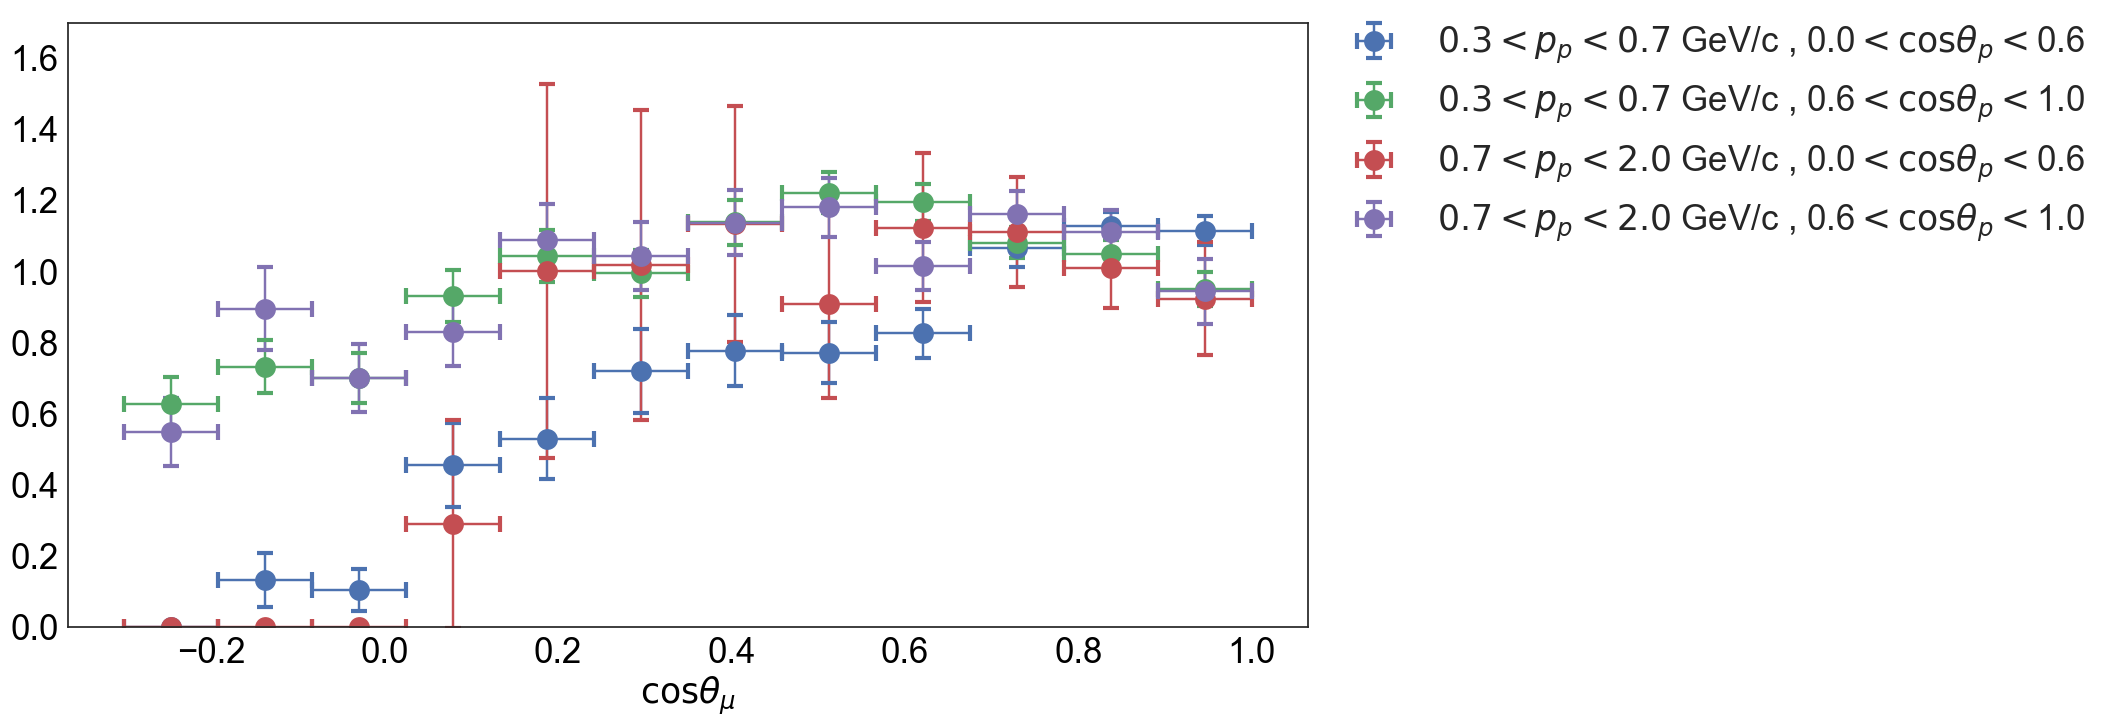

In [67]:
fig,ax=plt.subplots(figsize=(16,8))
for iPp,(Pp_min,Pp_max) in enumerate(zip(large_bins_Pp_min,large_bins_Pp_max)):
    for iPp_cos_theta,(Pp_cos_theta_min,Pp_cos_theta_max) in enumerate(zip(large_bins_Pp_cos_theta_min,large_bins_Pp_cos_theta_max)):
        key = 'iPp %d iPp_cos_theta %d'%(iPp,iPp_cos_theta)
        ax.errorbar(x=mid_Pmu_cos_theta,xerr=0.5*bin_width_Pmu_cos_theta,y=heff[key],yerr=heff_err[key]
                    ,fmt='o',markersize=15,capsize=6,capthick=3
                    ,label=r'$%.1f<p_p<%.1f$ GeV/c , %s$<\cos\theta_p<$%s'%(Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max))        
set_axes(ax,r'$\cos\theta_\mu$',ylim=(0,1.7))
ax.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

## 2D efficiency

In [5]:
h_p_eff,h_p_eff_err = dict(),dict()
h_p_gen,h_p_acc = dict(),dict()
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        selected_CC1p_muon_bin = sample_in_muon_bin(selected_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
        genie_CC1p_muon_bin = sample_in_muon_bin(genie_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)        

        hCC1p_muon_bins[iPmu][iPmu_cos_theta] = len(selected_CC1p_muon_bin)
        
        # now check the proton acceptance in this muon-kinematics bin
        hgen,hacc,heff,heff_err = np.zeros((nx_p,ny_p)),np.zeros((nx_p,ny_p)),np.zeros((nx_p,ny_p)),np.zeros((nx_p,ny_p))
        total_len_acc_proton_bin = 0
        for iPp in range(nx_p):
            Pp_min,Pp_max = Pp_bins[iPp],Pp_bins[iPp+1]    
            for iPp_cos_theta in range(ny_p):
                Pp_cos_theta_min,Pp_cos_theta_max = Pp_cos_theta_bins[iPp_cos_theta],Pp_cos_theta_bins[iPp_cos_theta+1]        
                # efficiency
                gen_proton_bin = sample_in_proton_bin(genie_CC1p_muon_bin,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)            
                hgen[iPp][iPp_cos_theta] = len(gen_proton_bin)        
                
                acc_proton_bin = sample_in_proton_bin(selected_CC1p_muon_bin,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)
                hacc[iPp][iPp_cos_theta] = len(acc_proton_bin)        
                heff[iPp][iPp_cos_theta] = float(hacc[iPp][iPp_cos_theta])/(hgen[iPp][iPp_cos_theta] if hgen[iPp][iPp_cos_theta]>0 else 1)
                heff_err[iPp][iPp_cos_theta] = heff[iPp][iPp_cos_theta]*np.sqrt( (1./hgen[iPp][iPp_cos_theta] 
                                                                                  if hgen[iPp][iPp_cos_theta] else 0)                                                                
                                                                                + (1./hacc[iPp][iPp_cos_theta] 
                                                                                   if hacc[iPp][iPp_cos_theta] else 0) )
        h_p_gen['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = hgen.T
        h_p_acc['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = hacc.T

        h_p_eff['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = heff.T
        h_p_eff_err['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = heff_err.T
print 'done.'

done.


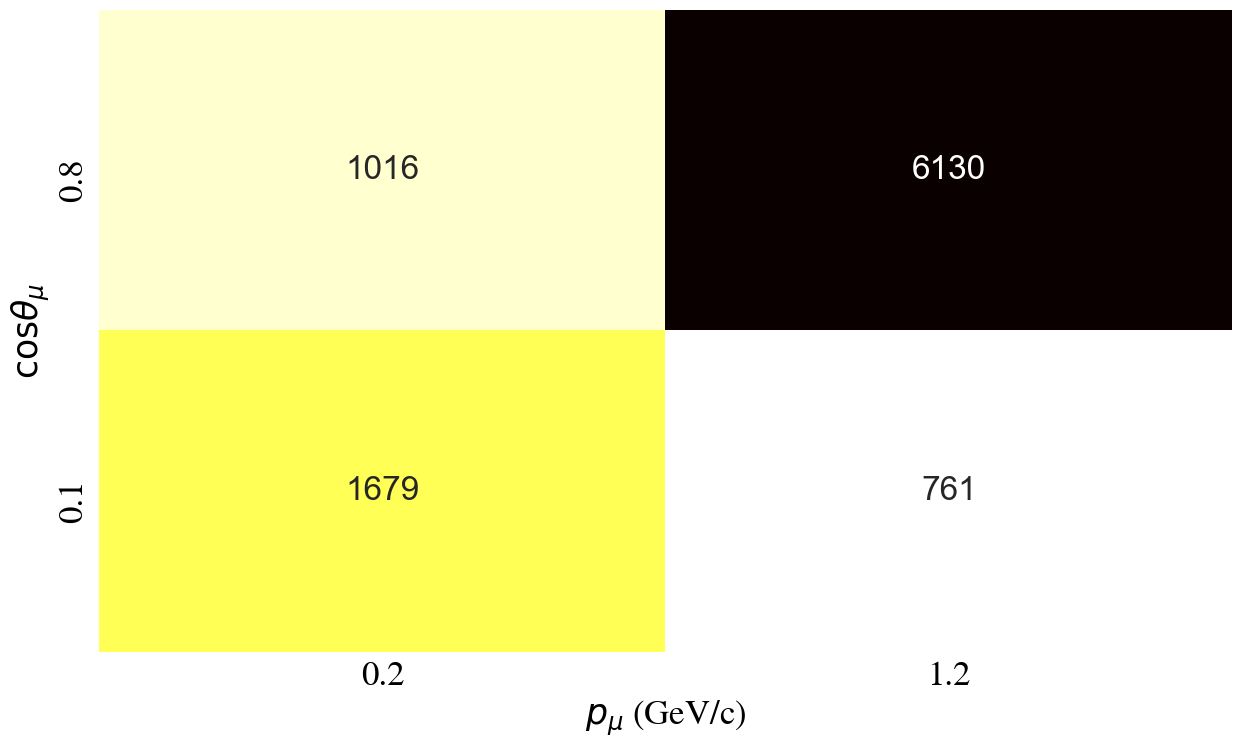

In [6]:
fig = plt.figure(figsize=(12.944,8))
ax = fig.add_subplot(1,1,1)
sns.set(font_scale=2);
sns.heatmap(hCC1p_muon_bins.T.astype(np.int),annot=True,cmap='hot_r',fmt="d"         
            ,xticklabels=["%.1f"%tick for tick in large_bins_Pmu_centers]
            ,yticklabels=["%.1f"%tick for tick in large_bins_Pmu_cos_theta_centers]
            ,cbar=False)
set_axes(ax,r'$p_\mu$ (GeV/c)',r'$\cos\theta_\mu$')
ax.invert_yaxis()
plt.tight_layout()

Integral: 1.64258881833
Integral: 1.63208343552
Integral: 1.72141573002
Integral: 1.91138815859


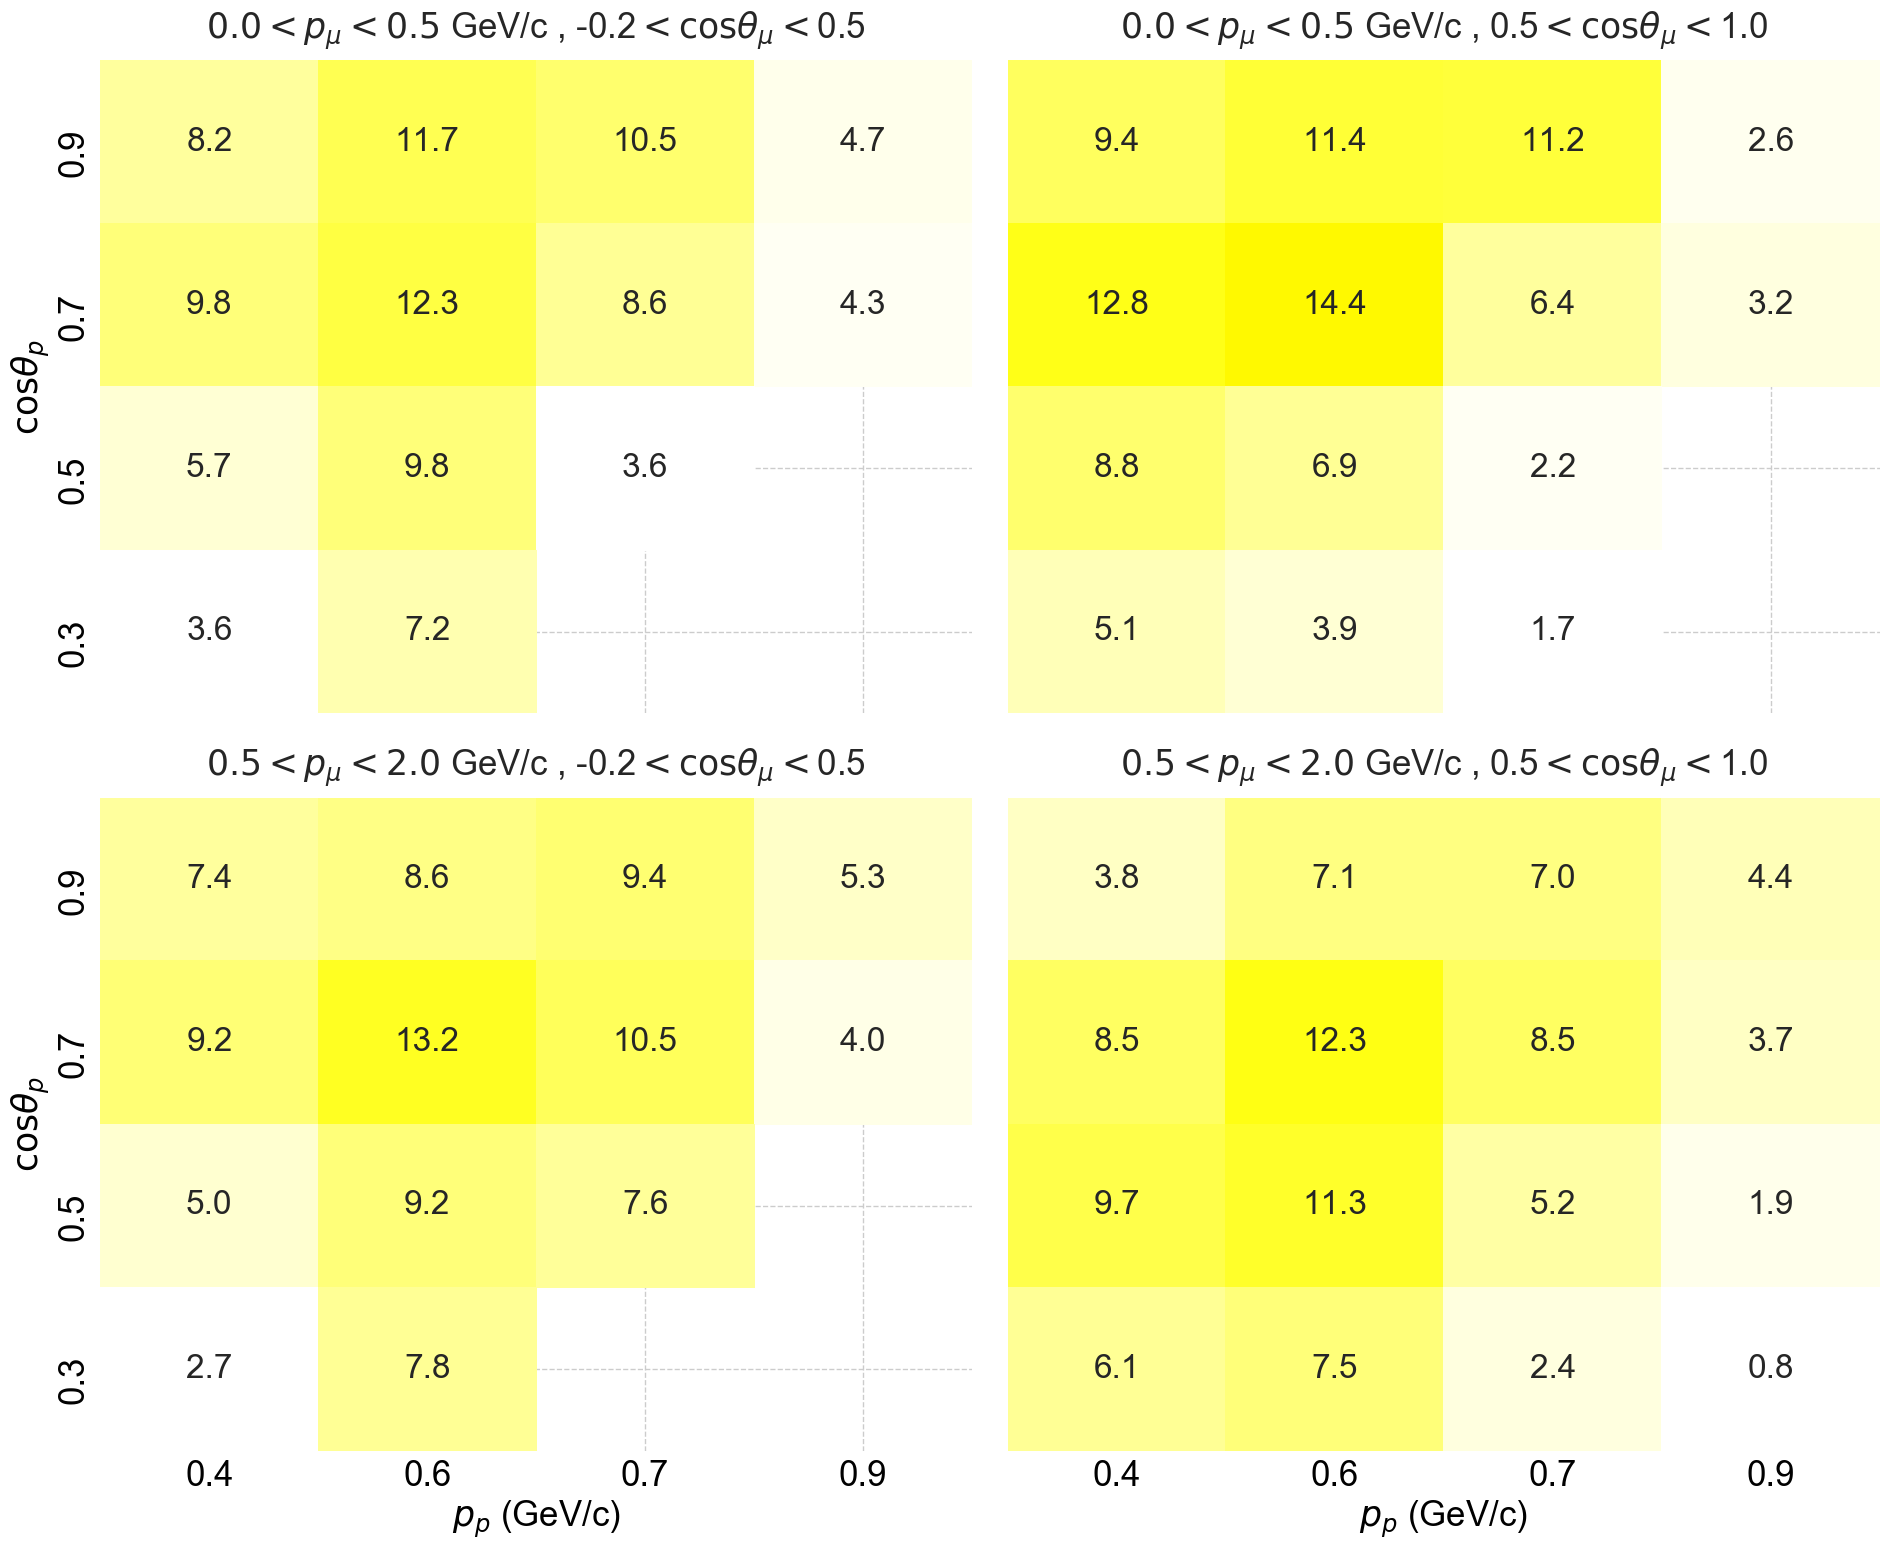

In [9]:
fig = plt.figure(figsize=(19.416,16))
sns.set_style('white')
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        ax = fig.add_subplot(2,2,2*iPmu+iPmu_cos_theta+1)
        histo = h_p_eff['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)]
        Integral = np.sum(h_p_eff['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)])
        print 'Integral:',Integral
        histo = histo/Integral
        histo[histo <= 0] = None
        sns.heatmap(100*histo,annot=True,cmap='hot_r',fmt=".1f",vmin=None,vmax=50
            ,xticklabels=["%.1f"%tick for tick in Pp_xcenters]
            ,yticklabels=["%.1f"%tick for tick in Pp_cos_theta_ycenters]
            ,cbar=False)
        set_axes(ax,do_add_grid=True,alpha_grid=1
                 ,x_label='' if iPmu==0 else  r'$p_p$ (GeV/c)'
                 ,remove_ticks_x=True if iPmu==0 else False
                 ,y_label=''  if iPmu_cos_theta==1 or iPmu_cos_theta==3 else  r'$\cos\theta_p$'
                 ,remove_ticks_y=True if iPmu_cos_theta==1 or iPmu_cos_theta==3 else False
                 ,title=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
                 )
        ax.invert_yaxis()
plt.tight_layout()

## generated and accepted

Integral: 13863.0
Integral: 8007.0
Integral: 6243.0
Integral: 47201.0


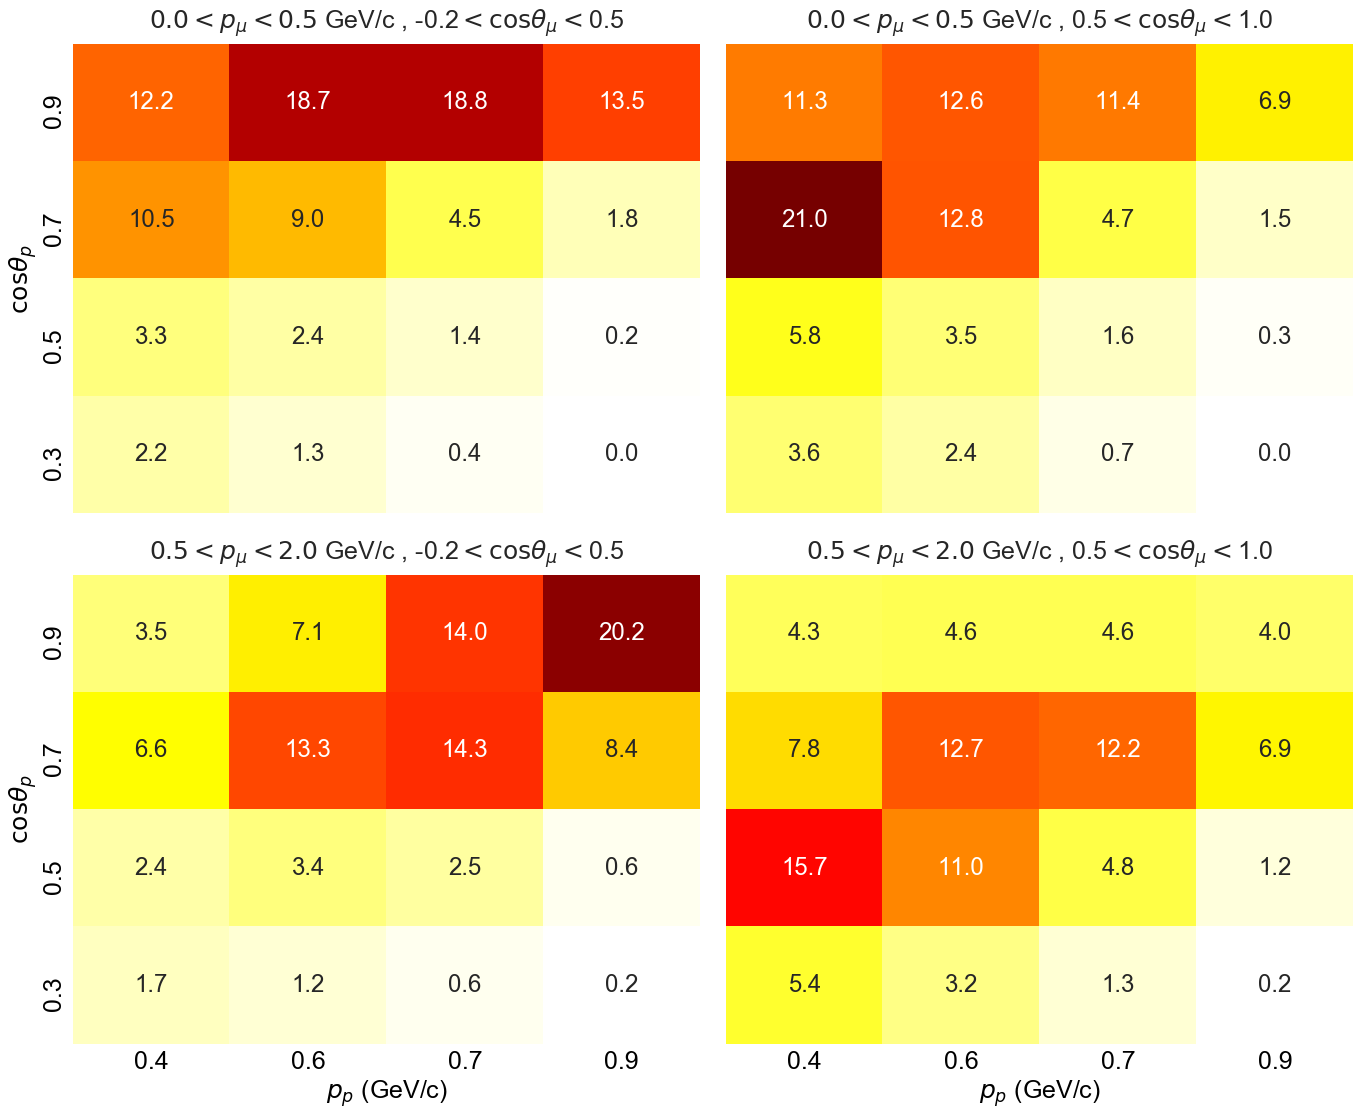

In [115]:
fig = plt.figure(figsize=(19.416,16))
sns.set_style('white')
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        ax = fig.add_subplot(2,2,2*iPmu+iPmu_cos_theta+1)
        histo = h_p_gen['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)]
        Integral = np.sum(h_p_gen['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)])
        print 'Integral:',Integral
        histo = histo/Integral
        histo[histo <= 0] = None
        sns.heatmap(100*histo,annot=True,cmap='hot_r',fmt=".1f",vmin=None,vmax=25
            ,xticklabels=["%.1f"%tick for tick in Pp_xcenters]
            ,yticklabels=["%.1f"%tick for tick in Pp_cos_theta_ycenters]
            ,cbar=False)
        set_axes(ax,do_add_grid=True,alpha_grid=1
                 ,x_label='' if iPmu==0 else  r'$p_p$ (GeV/c)'
                 ,remove_ticks_x=True if iPmu==0 else False
                 ,y_label=''  if iPmu_cos_theta==1 or iPmu_cos_theta==3 else  r'$\cos\theta_p$'
                 ,remove_ticks_y=True if iPmu_cos_theta==1 or iPmu_cos_theta==3 else False
                 ,title=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
                 )
        ax.invert_yaxis()
plt.tight_layout()

fig = plt.figure(figsize=(19.416,16))
sns.set_style('white')
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        ax = fig.add_subplot(2,2,2*iPmu+iPmu_cos_theta+1)
        histo = h_p_acc['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)]
        Integral = np.sum(h_p_acc['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)])
        histo = histo/Integral
        histo[histo <= 0] = None
        sns.heatmap(100*histo,annot=True,cmap='hot_r',fmt=".1f",vmin=None,vmax=25
            ,xticklabels=["%.1f"%tick for tick in Pp_xcenters]
            ,yticklabels=["%.1f"%tick for tick in Pp_cos_theta_ycenters]
            ,cbar=False)
        set_axes(ax,do_add_grid=True,alpha_grid=1
                 ,x_label='' if iPmu==0 else  r'$p_p$ (GeV/c)'
                 ,remove_ticks_x=True if iPmu==0 else False
                 ,y_label=''  if iPmu_cos_theta==1 or iPmu_cos_theta==3 else  r'$\cos\theta_p$'
                 ,remove_ticks_y=True if iPmu_cos_theta==1 or iPmu_cos_theta==3 else False
                 ,title=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
                 )
        ax.invert_yaxis()
plt.tight_layout()